# <center style='color:deeppink'> AutoEncoder (AE) - Example using USPS dataset </center>

## 1. Import the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the device

In [2]:
print('PyTorch version:', torch.__version__, '\n')
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

PyTorch version: 2.0.1+cu117 

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


## 3. load USPS dataset

In [3]:
training_dataset = datasets.USPS('./data_src', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.USPS('./data_src', train=False, download=True, transform=transforms.ToTensor())

100%|███████████████████████████████████████████████| 6579383/6579383 [00:00<00:00, 18798242.26it/s]


100%|████████████████████████████████████████████████| 1831726/1831726 [00:00<00:00, 6382634.70it/s]


In [4]:
# check the length of training and test datasets

print('Length of the training dataset:', len(training_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 7291
Length of the test dataset: 2007


#### In total, there are `7291 samples (images)` in the `training set` and `2007 samples (images)` in the `test set`

In [5]:
# check the shape of training and test datasets

print('Shape of the training dataset:', training_dataset.data.shape)
print('Shape of the test dataset:', test_dataset.data.shape)

Shape of the training dataset: (7291, 16, 16)
Shape of the test dataset: (2007, 16, 16)


Shape: (total images, height, width)

#### The `spatial dimension` of the `grayscale images` in the `USPS dataset` is `16x16` pixels

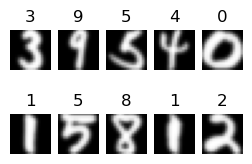

In [6]:
# show 10 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=2, ncols=5, figsize=(3, 2))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='Greys_r')
    ax.set_title(training_dataset.targets[inx], fontsize=12)
    ax.axis(False);

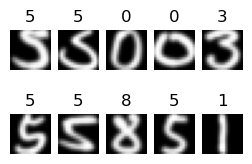

In [7]:
# show 10 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=2, ncols=5, figsize=(3, 2))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='Greys_r')
    ax.set_title(test_dataset.targets[inx], fontsize=12)
    ax.axis(False);

## 4. Define dataloaders

In [8]:
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [9]:
# check the length of training and test dataloaders

print('Length of the training dataloader:', len(training_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

Length of the training dataloader: 227
Length of the test dataloader: 62


Since, neither 7291 nor 2007 is divisible by 32; the last batch will not have 32 images in it and hence I dropped it. 227 and 62 are showing the number of batches in training and test dataloaders, respectively.

#### Dataloader converts a dataset into an iterable

## 5. Define the network architecture

In [10]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential()
        self.encoder.add_module('linear1', nn.Linear(in_features=16*16, out_features=128))
        self.encoder.add_module('relu1', nn.ReLU(inplace=True))
        self.encoder.add_module('linear2', nn.Linear(in_features=128, out_features=64))
        self.encoder.add_module('relu2', nn.ReLU(inplace=True))
        self.encoder.add_module('linear3', nn.Linear(in_features=64, out_features=40))
        
        self.decoder = nn.Sequential()
        self.decoder.add_module('linear3', nn.Linear(in_features=40, out_features=64))
        self.decoder.add_module('relu3', nn.ReLU(inplace=True))
        self.decoder.add_module('linear2', nn.Linear(in_features=64, out_features=128))
        self.decoder.add_module('relu2', nn.ReLU(inplace=True))
        self.decoder.add_module('linear1', nn.Linear(in_features=128, out_features=16*16))
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 16, 16)
        return x

## 6. Visualize the model architecture

In [11]:
model = AE().to(device)
summary(model, input_size=(32, 1, 16, 16))

Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [32, 1, 16, 16]           --
├─Sequential: 1-1                        [32, 40]                  --
│    └─Linear: 2-1                       [32, 128]                 32,896
│    └─ReLU: 2-2                         [32, 128]                 --
│    └─Linear: 2-3                       [32, 64]                  8,256
│    └─ReLU: 2-4                         [32, 64]                  --
│    └─Linear: 2-5                       [32, 40]                  2,600
├─Sequential: 1-2                        [32, 256]                 --
│    └─Linear: 2-6                       [32, 64]                  2,624
│    └─ReLU: 2-7                         [32, 64]                  --
│    └─Linear: 2-8                       [32, 128]                 8,320
│    └─ReLU: 2-9                         [32, 128]                 --
│    └─Linear: 2-10                      [32, 256]                 33

## 7. Define the training batch

In [12]:
def training_batch(data, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    output = model(data)
    loss = criterion(output, data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

## 8. Define the test batch

In [13]:
with torch.inference_mode():
    def test_batch(data, model, criterion):
        model.eval()
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data)
        return loss

## 9. Set up model (`AE`), criterion (`loss function`) and optimizer

In [14]:
ae = AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.001)

## 10. Train the model

In [15]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 100

training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in training_dataloader:
        trng_batch_loss = training_batch(data, ae, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    for data, _ in test_dataloader:
        tst_batch_loss = test_batch(data, ae, criterion)
        test_losses.append(tst_batch_loss.item())
    test_per_epoch_loss = np.array(test_losses).mean()
    
    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    if (epoch+1) % 10==0:
        print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
        print(f'Test loss: {test_per_epoch_loss:.4f}')

Epoch: 10/100	| Training loss: 0.0068 |   Test loss: 0.0077
Epoch: 20/100	| Training loss: 0.0046 |   Test loss: 0.0054
Epoch: 30/100	| Training loss: 0.0037 |   Test loss: 0.0042
Epoch: 40/100	| Training loss: 0.0032 |   Test loss: 0.0037
Epoch: 50/100	| Training loss: 0.0029 |   Test loss: 0.0034
Epoch: 60/100	| Training loss: 0.0027 |   Test loss: 0.0031
Epoch: 70/100	| Training loss: 0.0025 |   Test loss: 0.0029
Epoch: 80/100	| Training loss: 0.0024 |   Test loss: 0.0027
Epoch: 90/100	| Training loss: 0.0023 |   Test loss: 0.0028
Epoch: 100/100	| Training loss: 0.0022 |   Test loss: 0.0026


I trained the `AE` model for `100 epochs` only. However, you can obviously train it for a longer period of time and observe if the performance gets better or not! 

## 11. Plot model loss

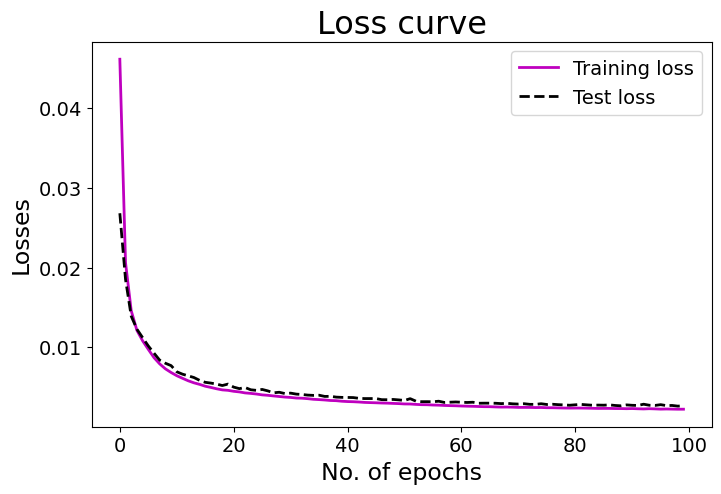

In [16]:
plt.figure(figsize=(8, 5))

plt.plot(training_loss, 'm-', linewidth=2, label='Training loss')
plt.plot(test_loss, 'k--', linewidth=2, label='Test loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=17)
plt.ylabel('Losses', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14);

## 12. Model prediction

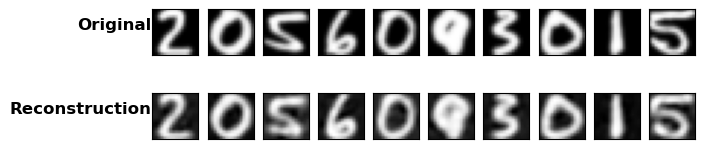

In [17]:
ORG, REC = [], []

for a in range(10):
    idx = np.random.randint(len(test_dataset))
    ORG.append(test_dataset[idx][0])
    REC.append(ae.cpu()(ORG[a]))  
    
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(7, 2))

for i in range(10):
    ax[0, i].imshow(ORG[i].squeeze(), cmap='Greys_r')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].imshow(REC[i].squeeze().cpu().detach().numpy(), cmap='Greys_r')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

ax[0, 0].set_ylabel('Original', fontsize=12, rotation=0, labelpad=24, fontweight='bold')
ax[1, 0].set_ylabel('Reconstruction', fontsize=12, rotation=0, labelpad=48, fontweight='bold');

We randomly selected 10 images from the test set and checked the corresponding `reconstruction` provided by the `AE` model.

It's very difficult to understand but you can notice that the reconstructed images are more blurry than their original counterparts. 